In [1]:
import re
import nltk
import random
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense, GlobalAveragePooling1D, SimpleRNN
#from sklearn.model_selection import RandomizedSearchCV
#from keras.wrappers.scikit_learn import KerasClassifier

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Load IMDb Dataset**

In [2]:
dataset ='/content/gdrive/My Drive/Colab Notebooks/IMBD_Dataset/IMDB Dataset.csv'
df = pd.read_csv(dataset)
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [3]:
df.sentiment = [1 if s == 'positive' else 0 for s in df.sentiment]
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


**Data Preprocessing**

In [4]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
idx = random.randint(0, len(df)-1)
before_process = df.iloc[idx][0]

def process(x):
    x = re.sub('[,\.!?:()"]', '', x)
    x = re.sub('<.*?>', ' ', x)
    x = re.sub('http\S+', ' ', x)
    x = re.sub('[^a-zA-Z0-9]', ' ', x)
    x = re.sub('\s+', ' ', x)
    return x.lower().strip()

df['review'] = df['review'].apply(lambda x: process(x))
after_process = df.iloc[idx][0]

sw_set = set(nltk.corpus.stopwords.words('english'))

def sw_remove(x):
    words = nltk.tokenize.word_tokenize(x)
    filtered_list = [word for word in words if word not in sw_set]
    return ' '.join(filtered_list)

df['review'] = df['review'].apply(lambda x: sw_remove(x))
after_removal = sw_remove(after_process)

**Test Train Splitting of Data**

In [6]:
train_rev, test_rev, train_sent, test_sent = train_test_split(df['review'], df['sentiment'], test_size=0.1, random_state=42)

print('train_rev.shape(Training Review):', train_rev.shape)
print('test_rev.shape(Testing Review):', test_rev.shape)
print('train_sent.shape(Training Sentiment):', train_sent.shape)
print('test_sent.shape(Training Sentiment):', test_sent.shape)


train_rev.shape(Training Review): (45000,)
test_rev.shape(Testing Review): (5000,)
train_sent.shape(Training Sentiment): (45000,)
test_sent.shape(Training Sentiment): (5000,)


**Tokenization**

In [7]:
dict_size = 35000
tokenizer = Tokenizer(num_words=dict_size)
tokenizer.fit_on_texts(df['review'])

print('Dictionary size:', dict_size)
print('Length of the tokenizer index:' , len(tokenizer.word_index))
print('Number of documents the tokenizer was trained on:' , tokenizer.document_count, '\n')
print('First 20 entries of the tokenizer index:')
print(*list(tokenizer.word_index.items())[:20])

train_rev_tokens = tokenizer.texts_to_sequences(train_rev)
test_rev_tokens = tokenizer.texts_to_sequences(test_rev)
seq_lengths =  np.array([len(sequence) for sequence in train_rev_tokens])

upper_bound = int(np.mean(seq_lengths) + 2 * np.std(seq_lengths))
percentage = stats.percentileofscore(seq_lengths, upper_bound)

Dictionary size: 35000
Length of the tokenizer index: 125791
Number of documents the tokenizer was trained on: 50000 

First 20 entries of the tokenizer index:
('movie', 1) ('film', 2) ('one', 3) ('like', 4) ('good', 5) ('time', 6) ('even', 7) ('would', 8) ('really', 9) ('story', 10) ('see', 11) ('well', 12) ('much', 13) ('get', 14) ('bad', 15) ('people', 16) ('great', 17) ('also', 18) ('first', 19) ('made', 20)


**Pad Sequencing the data**

In [8]:
train_rev_pad = pad_sequences(train_rev_tokens, maxlen=upper_bound)
test_rev_pad = pad_sequences(test_rev_tokens, maxlen=upper_bound)

# Printing an example of review after padding
idx_pad = random.randint(0, len(train_rev_pad)-1)
print('\033[1m' + 'Review #%d after padding:' %idx_pad + '\033[0m' + '\n', train_rev_pad[idx_pad])


Review #27259 after padding:
 [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0   

**Glove Embedding Matrix Creation**

In [9]:
glove_path = '/content/gdrive/My Drive/Colab Notebooks/glove.6B/glove.6B.100d.txt'


def create_embedding_matrix(embedding_path, word_index, embedding_dim):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    print("Embedding matrix shape: %s" % str(embedding_matrix.shape))

    with open(embedding_path, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(values[1:], dtype="float32")
            return embedding_matrix


In [10]:
embedding_dimension =100
embedding_matrix = create_embedding_matrix(glove_path, tokenizer.word_index, embedding_dimension)

Embedding matrix shape: (125792, 100)


**Defining a plot function**

In [11]:
def draw_graph(fitted, epochs, state_dim, batch_size):
  ep_values = range(1, epochs+1)

  _, (loss, acc) = plt.subplots(1, 2, figsize=(12, 5))

  loss.plot(ep_values, fitted.history['loss'], color='red', linestyle='-',
              marker='*', label='Training loss (binary cross-entropy)')
  loss.plot(ep_values, fitted.history['val_loss'], color='black', linestyle='--',
              marker='*', label='Validation loss (binary cross-entropy)')

  loss.set_xlabel('Epoch', size='medium')
  loss.legend(fontsize='medium')

  acc.plot(ep_values, fitted.history['accuracy'], color='red', linestyle='-',
             marker='*', label='Training accuracy')
  acc.plot(ep_values, fitted.history['val_accuracy'], color='black', linestyle='--',
             marker='*', label='Validation accuracy')

  acc.set_xlabel('Epoch', size='medium')
  acc.legend(fontsize='medium')

  plt.show()

**LSTM Model**

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 291, 100)          12579200  
                                                                 
 lstm_1 (LSTM)               (None, 291, 20)           9680      
                                                                 
 global_average_pooling1d_1  (None, 20)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 12588901 (48.02 MB)
Trainable params: 12588901 (48.02 MB)
Non-trainable params: 0 (0.00 Byte)
____________

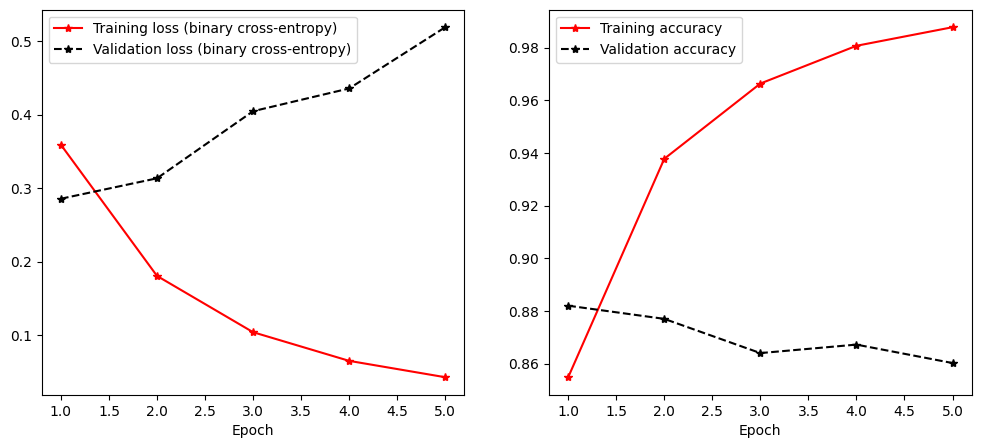

157/157 [==============================] - 10s 55ms/step - loss: 0.4615 - accuracy: 0.8698
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 291, 100)          12579200  
                                                                 
 lstm_2 (LSTM)               (None, 291, 50)           30200     
                                                                 
 global_average_pooling1d_2  (None, 50)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 12609451 (48.10

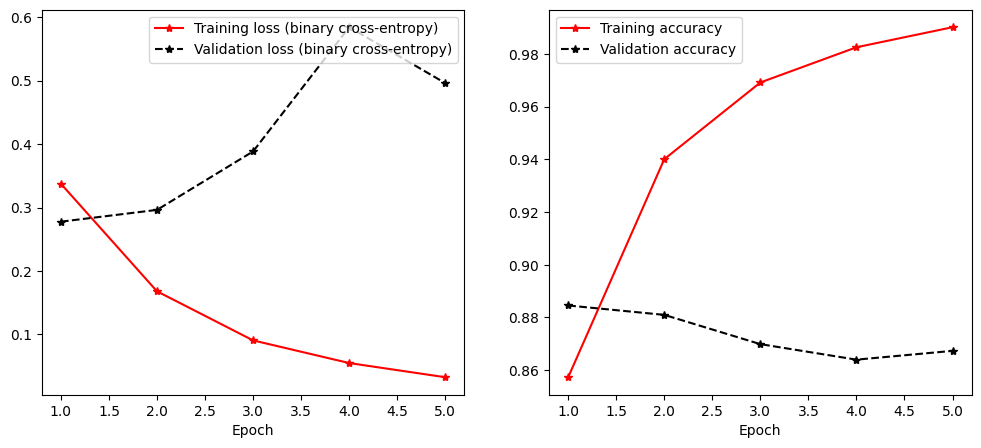

157/157 [==============================] - 9s 53ms/step - loss: 0.4465 - accuracy: 0.8742
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 291, 100)          12579200  
                                                                 
 lstm_3 (LSTM)               (None, 291, 100)          80400     
                                                                 
 global_average_pooling1d_3  (None, 100)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 12659701 (48.29 

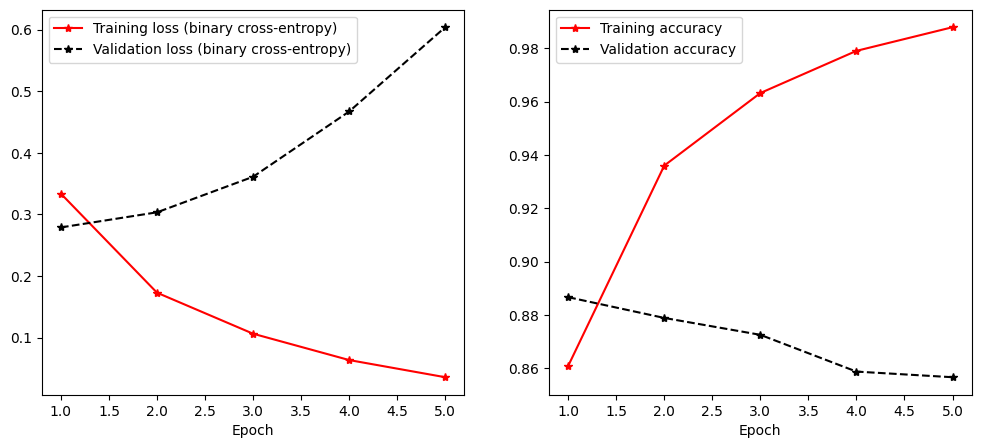

157/157 [==============================] - 10s 54ms/step - loss: 0.5679 - accuracy: 0.8630
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 291, 100)          12579200  
                                                                 
 lstm_4 (LSTM)               (None, 291, 200)          240800    
                                                                 
 global_average_pooling1d_4  (None, 200)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_4 (Dropout)         (None, 200)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 201       
                                                                 
Total params: 12820201 (48.91

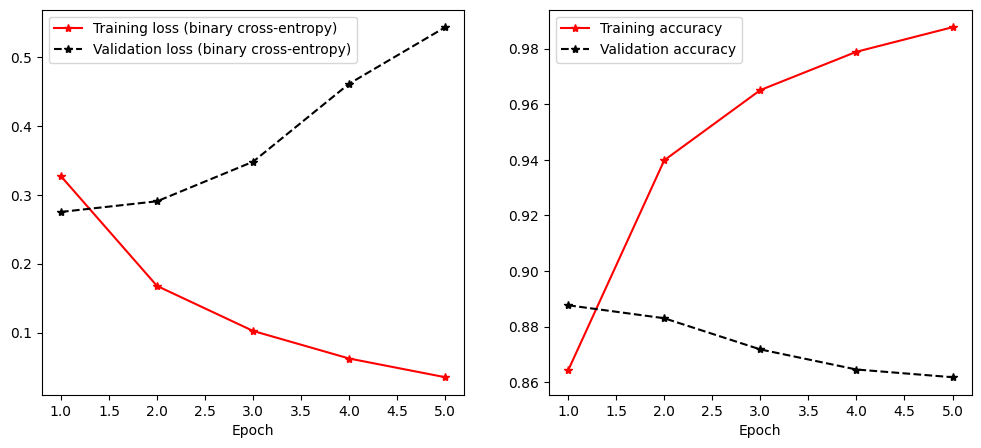

157/157 [==============================] - 10s 57ms/step - loss: 0.4986 - accuracy: 0.8724
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 291, 100)          12579200  
                                                                 
 lstm_5 (LSTM)               (None, 291, 500)          1202000   
                                                                 
 global_average_pooling1d_5  (None, 500)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_5 (Dropout)         (None, 500)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 501       
                                                                 
Total params: 13781701 (52.57

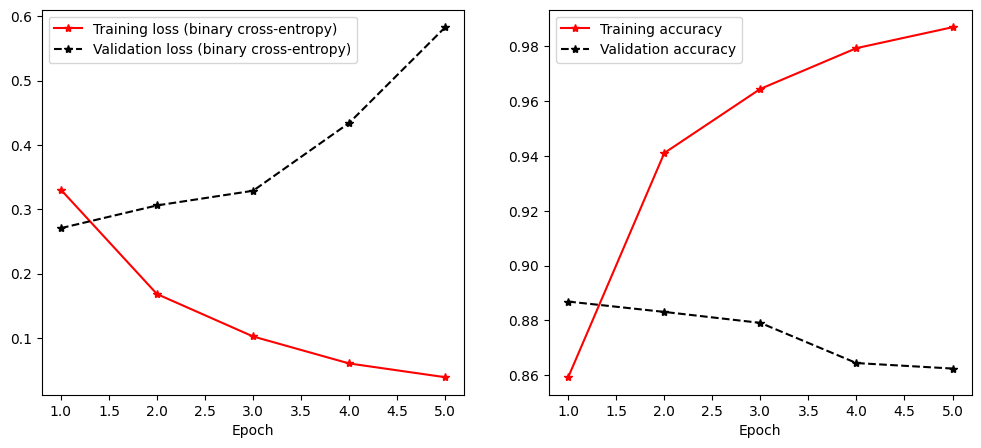

157/157 [==============================] - 9s 53ms/step - loss: 0.5053 - accuracy: 0.8764


In [13]:
validation_split = 0.2
batch_size = 50
epochs = 5
state_dimensions = [20, 50, 100, 200, 500]

for state_dim in state_dimensions:
  model = Sequential()
  model.add(Embedding(len(tokenizer.word_index)+1, embedding_dimension, input_length=upper_bound, weights=[embedding_matrix], trainable=True, mask_zero=True))
  model.add(LSTM(state_dim, return_sequences=True))
  model.add(GlobalAveragePooling1D())
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid')) # Logistic regression classifier

  model.summary() #Model Summary

  model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy']) #Compling the model

  fitted = model.fit(train_rev_pad, train_sent, validation_split=validation_split, batch_size=batch_size, epochs=epochs, shuffle=True)

  draw_graph(fitted, epochs, state_dim, batch_size) #plotting the loss and accuracy

  result= model.evaluate(test_rev_pad, test_sent)

**RNN Model**

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 291, 100)          12579200  
                                                                 
 simple_rnn (SimpleRNN)      (None, 291, 20)           2420      
                                                                 
 global_average_pooling1d_6  (None, 20)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_6 (Dropout)         (None, 20)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 21        
                                                                 
Total params: 12581641 (48.00 MB)
Trainable params: 12581641 (48.00 MB)
Non-trainable params: 0 (0.00 Byte)
____________

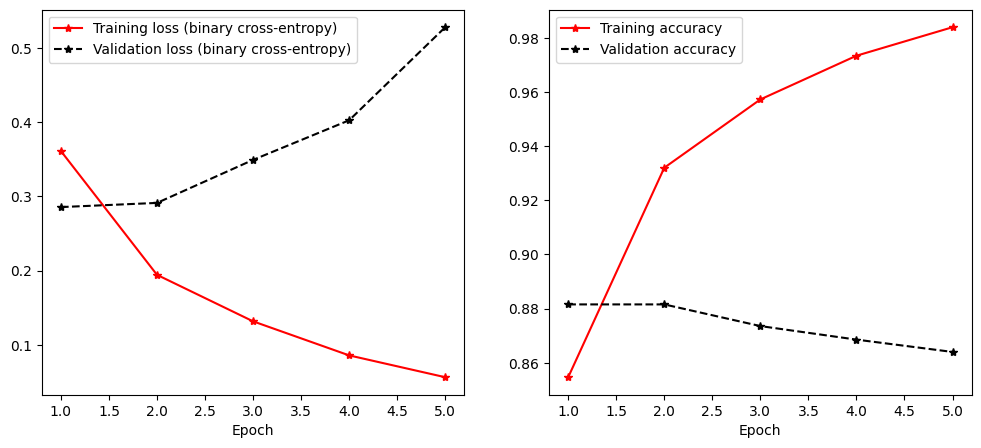

157/157 [==============================] - 5s 33ms/step - loss: 0.4870 - accuracy: 0.8696
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 291, 100)          12579200  
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 291, 50)           7550      
                                                                 
 global_average_pooling1d_7  (None, 50)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_7 (Dropout)         (None, 50)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 12586801 (48.01 

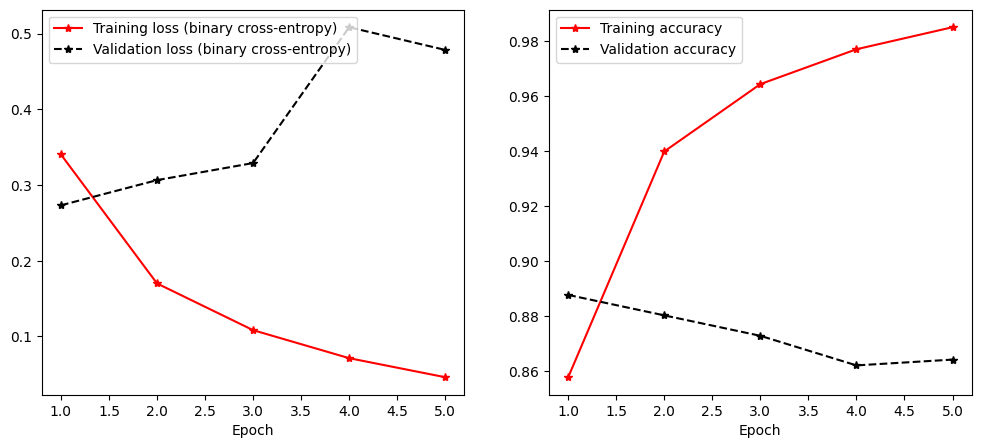

157/157 [==============================] - 5s 31ms/step - loss: 0.4257 - accuracy: 0.8740
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 291, 100)          12579200  
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 291, 100)          20100     
                                                                 
 global_average_pooling1d_8  (None, 100)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_8 (Dropout)         (None, 100)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 101       
                                                                 
Total params: 12599401 (48.06 

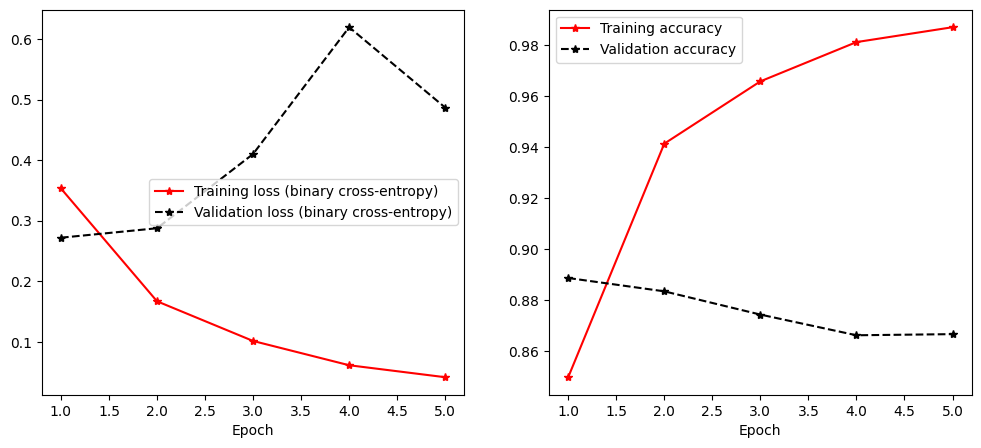

157/157 [==============================] - 5s 32ms/step - loss: 0.4159 - accuracy: 0.8782
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 291, 100)          12579200  
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 291, 200)          60200     
                                                                 
 global_average_pooling1d_9  (None, 200)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_9 (Dropout)         (None, 200)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 201       
                                                                 
Total params: 12639601 (48.22 

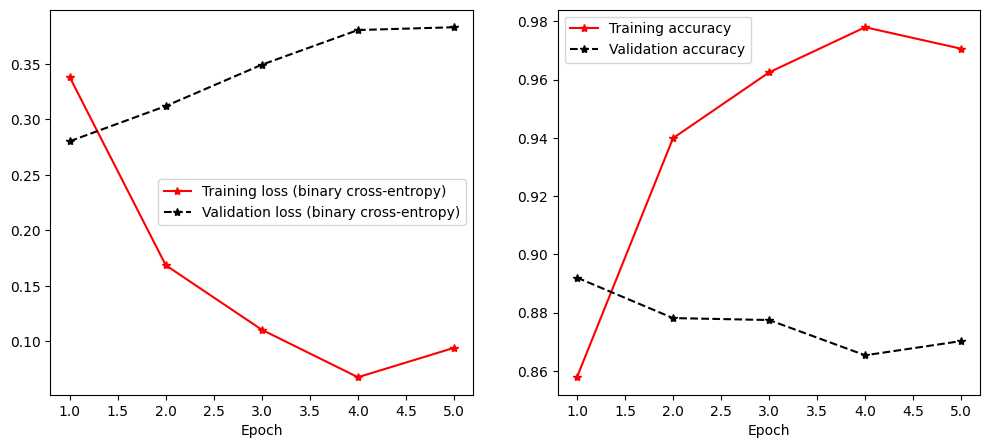

157/157 [==============================] - 5s 32ms/step - loss: 0.3479 - accuracy: 0.8758
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 291, 100)          12579200  
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 291, 500)          300500    
                                                                 
 global_average_pooling1d_1  (None, 500)               0         
 0 (GlobalAveragePooling1D)                                      
                                                                 
 dropout_10 (Dropout)        (None, 500)               0         
                                                                 
 dense_10 (Dense)            (None, 1)                 501       
                                                                 
Total params: 12880201 (49.13

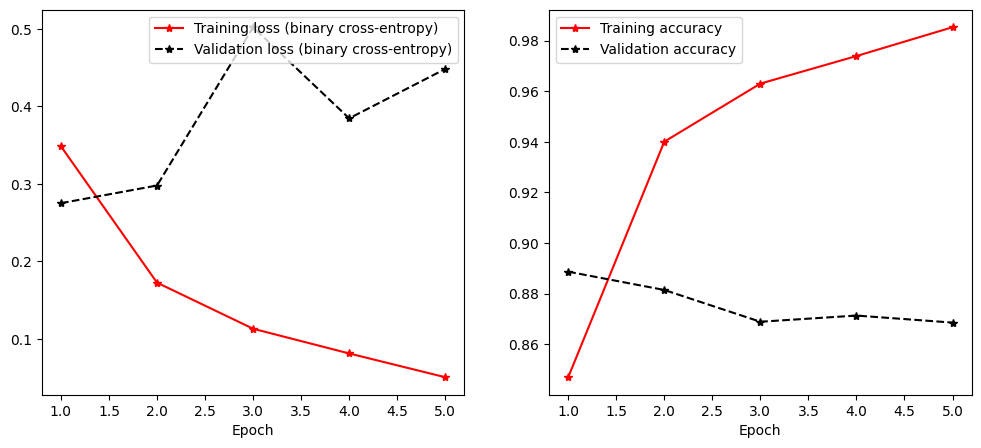

157/157 [==============================] - 6s 35ms/step - loss: 0.4035 - accuracy: 0.8760


In [14]:
for state_dim in state_dimensions:
  model = Sequential()
  model.add(Embedding(len(tokenizer.word_index)+1, embedding_dimension, input_length=upper_bound, weights=[embedding_matrix], trainable=True, mask_zero=True))
  model.add(SimpleRNN(state_dim, return_sequences=True))
  model.add(GlobalAveragePooling1D())
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid')) # Logistic regression classifier

  model.summary() #Model Summary

  model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy']) #Compling the model

  fitted = model.fit(train_rev_pad, train_sent, validation_split=validation_split, batch_size=batch_size, epochs=epochs, shuffle=True)

  draw_graph(fitted, epochs, state_dim, batch_size) #plotting the loss and accuracy

  result= model.evaluate(test_rev_pad, test_sent)